# Problem 2

2a)

- Implement your own, vectorized, version of the logistic regression discrimination algorithm. (Gradient decent) 

- It might help if you first write it as pseudo-code before you do the actual implementation!
- Note that this is challenging! if you found this too challenging, you may iterate over the samples. however, do not iterate over the dimensions of the features. 

- In the file tictac_end.csv, the end configurations 958 different tic-tac-toe games are provided. Each row represents a different outcome, with the first element being 1 if player x won, and 0 otherwise. The rest of the row represents the board, such that, when reshaped to a 3 x 3 array, the original board ir recovered. 

In [182]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import xlabel
import matplotlib.pyplot as plt



def sigmoid(z) :
  return 1/(1+np.exp(-z))

In [183]:

def gradient_descent(X: np.ndarray, y: np.ndarray) :
    # X will need the bias column as the first column
    N, d = X.shape  # N samples in d-1 features
    # w = np.random.randn(d,1)   # The + 1 is due to the bias...
    rng = np.random.default_rng()
    w = rng.standard_normal((d,1))   
    numIter = 0  # Inital number of iterations
    eta = 0.5    # Learning rate
    prev_error = 0
    total_error = 1
    tolerance = 0.0000001
    training_errors = []
    while abs(total_error - prev_error) > tolerance :
        prev_error = total_error
        z = X @ w
        h = sigmoid(z).reshape(z.size,1)
        
        grad = (X.T @ (h - y))/N   # Gradients. Need to transpose X so it will fit the matrix multiplication.
        w = w - eta*grad
        total_error = (np.sqrt((h - y).T @ (h - y)/N))
        numIter += 1
        training_errors.append(total_error.item())
        # print (total_error)

    return w, numIter, training_errors

### 2b) 

Test your classifier using the tic-tac-toe end-game dataset. Report the confusion matrix and the classification accuracy.


In [184]:


data = pd.read_csv("tictac-end.csv", skiprows=7, delimiter=" ")
data = data.sample(frac=1.0, replace=False)
X = data.iloc[:, 1:].to_numpy() # get all columns but the first one 
y = data.iloc[:,0].to_numpy() # get the first column

N , d = X.shape
endTrain = int(N*0.7)

# Splitting up into training and test sets for X (games) and y (outcome 1 or 0)
X_train = X[:endTrain,:]
X_test = X[endTrain+1:,:]

y = np.reshape(y, (N,1)) # shape it as one colum 
y_train = y[:endTrain,:]
y_test = y[endTrain+1:,:]

# Bias
bias = np.ones((endTrain,1))
X_train = np.concatenate((bias, X_train), axis=1) # Added bias column to X_train


w, epochs, errors = gradient_descent(X_train, y_train)
print("Number of epochs until convergence: ", epochs)



Number of epochs until convergence:  15510


## Making predictions on the Test set

In [185]:
def predict(w, X):
  z = X @ w
  probabilities = sigmoid(z)
  return (probabilities >= 0.5).astype(int)
  


bias = np.ones((X_test.shape[0],1))
X_test = np.concatenate((bias,X_test), axis=1)

# Training Accuracy
y_pred = predict(w, X_train)
accuracy = np.mean(y_pred == y_train)
print("Accuracy on the training set: ", accuracy)

# Test Accuracy
y_pred = predict(w, X_test)
accuracy = np.mean(y_pred == y_test)
print("Accuracy on the test set: ", accuracy)


Accuracy on the training set:  0.9880418535127056
Accuracy on the test set:  0.9721254355400697


# Confusion Matrix (without scikit-learn  )

#### 1. True positives (TP): Labels is 1, and the model predicted 1

In [186]:
TP = np.sum((y_test == 1) & (y_pred == 1))
print(f'TP, {TP}')


TP, 184


#### 2. True negatives (TN): Labels is 0, and the model predicted 0

In [187]:
TN = np.sum((y_test == 0) & (y_pred == 0))
print(f'TN, {TN}')

TN, 95


#### 3. False positives (FP): Labels is 0, but the model predicted 1

In [188]:
FP = np.sum((y_test == 0) & (y_pred == 1))
print(f'FP, {FP}')

FP, 8


#### 4. False negatives (FN): Labels is 1, and the model predicted 0

In [189]:
FN = np.sum((y_test == 1) & (y_pred == 0))
print(f'FN, {FN}')

FN, 0


## Creating the Confusion Matrix

In [190]:
confusion_matrix = np.array([[TN, FP], [FN, TP]])
print(f'Confusion Matrix: \n {confusion_matrix}')

Confusion Matrix: 
 [[ 95   8]
 [  0 184]]


# Plotting the loss over iterations

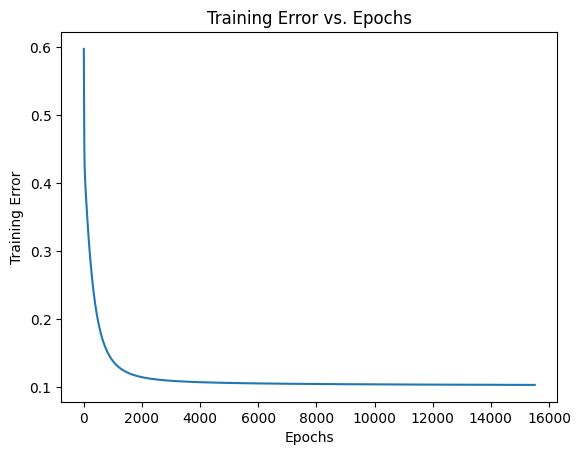

In [191]:
plt.plot(range(epochs), errors)
plt.xlabel('Epochs')
plt.ylabel('Training Error')
plt.title('Training Error vs. Epochs')
plt.show()

In [192]:
# Calculate TPR and FPR
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)

print("True Positive Rate (TPR):", TPR)
print("False Positive Rate (FPR):", FPR)

True Positive Rate (TPR): 1.0
False Positive Rate (FPR): 0.07766990291262135


## Plot the ROC (eceiver operating characteristics) curve 

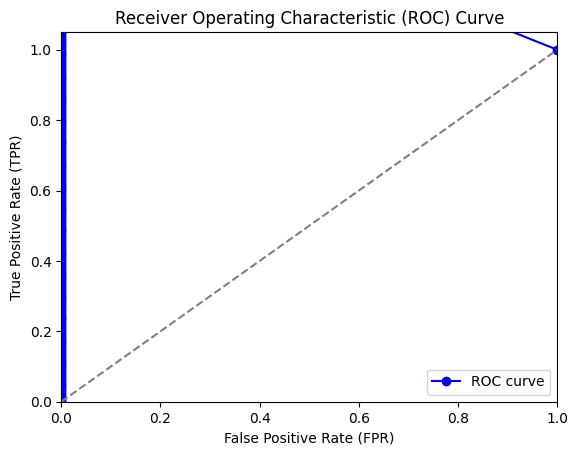

In [203]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your sigmoid function is defined correctly
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Assuming z = X_test @ w is correct and y_test contains true labels
z = X_test @ w
y_prob = sigmoid(z)

# Step 1: Sort by predicted probabilities (descending order)
sorted_indices = np.argsort(y_prob)[::-1]

y_prob_sorted = y_prob[sorted_indices]
y_test_sorted = y_test[sorted_indices]

# Step 2: Initialize variables to store the TPR and FPR
tpr_values = [0]  # Start from (0, 0)
fpr_values = [0]

# Total number of positives and negatives
total_positives = np.sum(y_test == 1)
total_negatives = np.sum(y_test == 0)

# Sanity check for total positives and negatives
if total_positives == 0 or total_negatives == 0:
    raise ValueError("The test set must contain both positive and negative samples.")

# Step 3: Manually calculate TPR and FPR at each threshold
TP = 0  # True positives counter
FP = 0  # False positives counter

# Loop over all sorted probabilities
for i in range(len(y_prob_sorted)):
    if y_test_sorted[i] == 1:  # If the current true label is positive
        TP += 1  # Increment true positives
    else:
        FP += 1  # Increment false positives
    
    # Calculate TPR and FPR for the current threshold
    TPR = TP / total_positives
    FPR = FP / total_negatives
    
    # Append the rates to their arrays
    tpr_values.append(TPR)
    fpr_values.append(FPR)

# Step 4: Append the final point (1,1) to the curve
tpr_values.append(1)
fpr_values.append(1)

# Step 5: Plot the ROC curve
plt.figure()
plt.plot(fpr_values, tpr_values, marker='o', linestyle='-', color='b', label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



### Calculate the AUC score 

In [202]:
auc = 0.0
for i in range(1, len(fpr_values)):
    auc += (fpr_values[i] - fpr_values[i-1]) * (tpr_values[i] + tpr_values[i-1]) / 2

print("AUC:", auc)

AUC: 1.2798913043478262
